# Data Visualization 

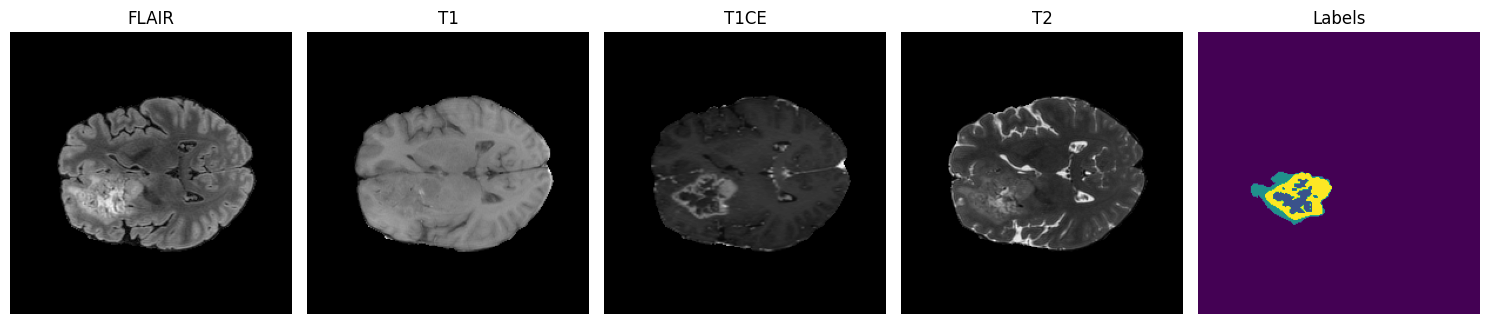

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

imgs = [nib.load(f"BraTS2021_Training_Data\\BraTS2021_00000\\BraTS2021_00000_{m}.nii.gz").get_fdata().astype(np.uint16)[:, :, 75] for m in ["flair", "t1", "t1ce", "t2"]]
lbl = nib.load(r"BraTS2021_Training_Data\BraTS2021_00000\BraTS2021_00000_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
titles = ["FLAIR", "T1", "T1CE", "T2", "Labels"]
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')

ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].set_title(titles[-1])
ax[-1].axis('off')

plt.tight_layout()            
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
imgs = nib.load(f"Task01_BrainTumour\\imagesTr\\BRATS_001.nii.gz").get_fdata().astype(np.uint16)
imgs2 = nib.load(f"images\\BraTS2021_00000.nii.gz").get_fdata().astype(np.uint16)
print(f'size of the image is {imgs.shape}')
print(f'size of the image  2 is {imgs2.shape}')

size of the image is (240, 240, 155, 4)
size of the image  2 is (240, 240, 155, 4)


# Dataset Creation 

In [ ]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed

def load_nifty(directory, example_id, suffix):
    print(directory , example_id)
    return nibabel.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    print(d , example_id)
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    print("here ")
    example_id = d.split("\\")[-1]
    print(example_id)
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "_seg_new.nii.gz"))


def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "_" in d.split('\\')[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "flair" in f or "t1" in f or "t1ce" in f or "t2" in f:
                    continue
                if "_seg_new" in f:
                    call(f"move \"{f}\" \"{lbl_path}\"", shell=True)
                if "_seg" in f:
                   continue
                else:
                    call(f"move \"{f}\" \"{img_path}\"", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + os.path.sep, "") for img in images])
    labels = sorted([lbl.replace(data + os.path.sep, "") for lbl in labels])

    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS21 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty,sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")
    
# prepare_dataset("/data/BraTS2021_train", True)
prepare_dataset(r"BraTS2021_Training_Data", True)
print("Finished!")

Preparing BraTS21 dataset from: BraTS2021_Training_Data
Preparing time: 586.09
Finished!


# Pre processing 

In [6]:
import os
import gc
import nibabel as nib
import numpy as np
import json
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler
import torchio as tio

TARGET_SPACING = [1.0, 1.0, 1.0]
TARGET_SIZE = [128, 128, 128]

def resample(image, target_spacing):
    zoom_factors = np.array(image.header.get_zooms()[:3]) / target_spacing
    data = image.get_fdata().astype(np.float32)  
    resampled = np.stack(
        [zoom(data[..., i], zoom_factors, order=1) for i in range(data.shape[-1])],
        axis=-1
    )
    return nib.Nifti1Image(resampled, affine=image.affine)

def resample_label(label, target_spacing):
    zoom_factors = np.array(label.header.get_zooms()[:3]) / target_spacing
    label_data = label.get_fdata().astype(np.int16)  
    resampled_label = zoom(label_data, zoom_factors, order=0) 
    return nib.Nifti1Image(resampled_label, affine=label.affine)

def crop_foreground(image, label=None):
    non_zero_coords = np.array(np.where(image.get_fdata() > 0))
    bbox_min, bbox_max = non_zero_coords.min(axis=1), non_zero_coords.max(axis=1)

    cropped_image_data = image.get_fdata()[bbox_min[0]:bbox_max[0], bbox_min[1]:bbox_max[1], bbox_min[2]:bbox_max[2], :]
    cropped_image = nib.Nifti1Image(cropped_image_data, affine=image.affine)
    
    if label:
        cropped_label_data = label.get_fdata()[bbox_min[0]:bbox_max[0], bbox_min[1]:bbox_max[1], bbox_min[2]:bbox_max[2]]
        cropped_label = nib.Nifti1Image(cropped_label_data, affine=label.affine)
        return cropped_image, cropped_label
    
    return cropped_image

def normalize_intensity(image):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(image.get_fdata().reshape(-1, 1)).reshape(image.shape)
    return nib.Nifti1Image(scaled_data, affine=image.affine)

def augment_image(image):
    subject = tio.Subject(img=tio.ScalarImage(tensor=image.get_fdata().transpose(3, 0, 1, 2)))
    transform = tio.Compose([
        tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
        tio.RandomAffine(scales=(0.9, 1.1), degrees=10),
        tio.RandomGamma(log_gamma=(-0.3, 0.3)),
    ])
    augmented_subject = transform(subject)
    augmented_image = augmented_subject['img'].numpy().transpose(1, 2, 3, 0)
    return nib.Nifti1Image(augmented_image, affine=image.affine)

def resize_to_target(image, target_size):
    current_shape = image.shape[:3]
    zoom_factors = [t / c for t, c in zip(target_size, current_shape)]
    resized_data = zoom(image, zoom_factors + [1] * (image.ndim - 3), order=1).astype(np.float32) 
    return resized_data



def preprocess_image(img_path, label_path, save_img_dir, save_label_dir):
    img = nib.load(img_path)
    label = nib.load(label_path) if label_path else None

    img = resample(img, TARGET_SPACING)
    if label:
        label = resample_label(label, TARGET_SPACING)

    if label:
        img, label = crop_foreground(img, label)
    else:
        img = crop_foreground(img)

    # img = normalize_intensity(img)

    img_array = resize_to_target(img.get_fdata(), TARGET_SIZE)
    
    if label:
        label_array = resize_to_target(label.get_fdata().astype(np.int16), TARGET_SIZE)  

    example_id = os.path.basename(img_path).split('.')[0]

    np.save(os.path.join(save_img_dir, f"{example_id}_img.npy"), img_array.astype(np.float32))
    if label:
        np.save(os.path.join(save_label_dir, f"{example_id}_label.npy"), label_array.astype(np.int16))

    del img, label, img_array, label_array
    gc.collect()

def preprocess_dataset(json_path, save_img_dir, save_label_dir):
    if not os.path.exists(save_img_dir):
        os.makedirs(save_img_dir)
    if not os.path.exists(save_label_dir):
        os.makedirs(save_label_dir)
    
    with open(json_path, "r") as f:
        dataset = json.load(f)
    
    for entry in dataset["training"]:
        img_path = entry["image"]
        label_path = entry["label"]
        preprocess_image(img_path, label_path, save_img_dir, save_label_dir)

# Define paths
json_file = r"dataset.json"
output_img_dir = r"numpy_image"
output_label_dir = r"numpy_label"
preprocess_dataset(json_file, output_img_dir, output_label_dir)

print("Numpy files are created for data")


Numpy files are created for data


In [8]:
# Visualizing the size of the data 
import numpy as np
npy_file_path =r'numpy_image\BraTS2021_00000_img.npy' 
data = np.load(npy_file_path)

print("Data shape:", data.shape)
print("Data size (number of elements):", data.size)
print("Data size in bytes:", data.nbytes)

Data shape: (128, 128, 128, 4)
Data size (number of elements): 8388608
Data size in bytes: 33554432


Data shape: (128, 128, 128, 4)
Data type: float32
Label shape: (128, 128, 128)
Label type: int16


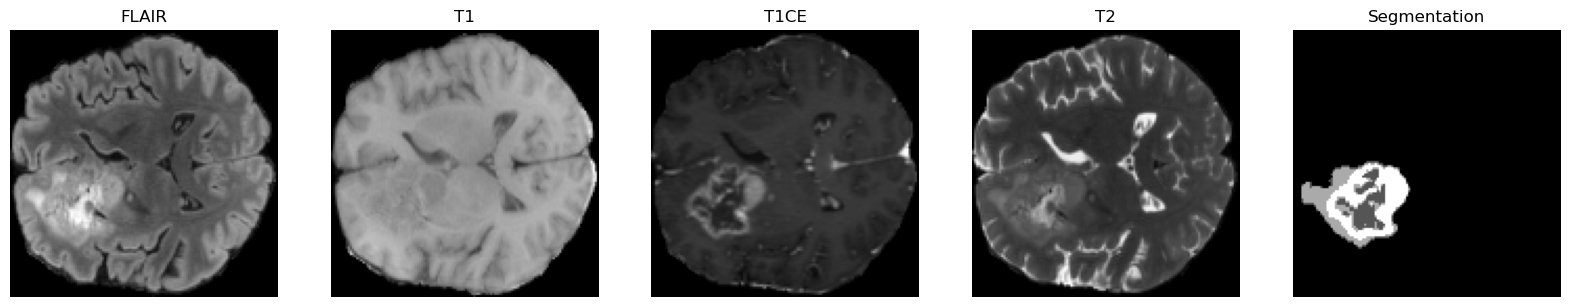

In [10]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load(r"numpy_image\BraTS2021_00000_img.npy")
label = np.load(r"numpy_label\BraTS2021_00000_label.npy")

print(f'Data shape: {data.shape}')
print(f"Data type: {data.dtype}")
print(f'Label shape: {label.shape}')
print(f"Label type: {label.dtype}")

slice_index = 65

titles = ["FLAIR", "T1", "T1CE", "T2", "Segmentation"]
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(4):
    img_slice = data[:, :, slice_index, i]
    axs[i].imshow(img_slice, cmap="gray")
    axs[i].set_title(titles[i])
    axs[i].axis("off")

label_slice = label[:, :, slice_index]
axs[4].imshow(label_slice, cmap="gray")
axs[4].set_title(titles[4])
axs[4].axis("off")

plt.show()


# dataset 

In [13]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class MRISegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('_img.npy')])
        self.label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('_label.npy')])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
       
        image = np.load(self.image_paths[idx]).astype(np.float32)
        label = np.load(self.label_paths[idx]).astype(np.int64)
        image = np.transpose(image, (3, 0, 1, 2))
        image_tensor = torch.tensor(image, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image_tensor, label_tensor

image_dir = r'numpy_image'
label_dir = r'numpy_label'

dataset = MRISegmentationDataset(image_dir, label_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for images, labels in dataloader:
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break 


Images batch shape: torch.Size([1, 4, 128, 128, 128])
Labels batch shape: torch.Size([1, 128, 128, 128])
